# 07 - Boeing network simplification

The Hausdorff distance first exploration can be found in notebooks > exploration > 00_network_data_transfer_exploration and 01_network_data_transfer_function.

The objective of this development is to simplify a network so that whenever there's a local avenue with two one-side streets, the network is simplified to one street only with all conections considered.

This development was __canceled__ due to its complex nature.

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [245]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

# Hausdorff Distance
from shapely import hausdorff_distance
# To know if it is a LineString or a MultiLineString
from shapely.geometry import LineString, MultiLineString
# For get_multiline_angle() function
import math
# To find Point coordinates
from shapely import Point

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [29]:
# Projection to be used whenever necessary
projected_crs = "EPSG:32618"

# Files directory for network_data_transfer exploration
nodes_network_dir = accesibilidad_urbana+ "data/external/volvo/input_osmnx_network/moravia_LH_osm_nodes.shp"
edges_network_dir = accesibilidad_urbana+ "data/external/volvo/input_osmnx_network/moravia_LH_osm_edges.shp"

print(nodes_network_dir)
print(edges_network_dir)

../../../data/external/volvo/input_osmnx_network/moravia_LH_osm_nodes.shp
../../../data/external/volvo/input_osmnx_network/moravia_LH_osm_edges.shp


## Input data

In [115]:
# Load nodes data
nodes = gpd.read_file(nodes_network_dir)


# Set CRS
if nodes.crs != projected_crs:
    try:
        nodes = nodes.set_crs(projected_crs)
    except:
        nodes = nodes.to_crs(projected_crs)

# Filter and rename data
print(list(nodes.columns))
nodes = nodes[['ID','geometry']]
nodes.rename(columns={'ID':'osmid'},inplace=True)

# Show
print(nodes.crs)
print(nodes.shape)
nodes.head(2)

['ID', 'coord_Y', 'coord_X', 'street_cou', 'coord_Z', 'highway', 'Type', 'geometry']
EPSG:32618
(554, 2)


,osmid,geometry
0,344185678,POINT (437311.645 692831.321)
1,344191636,POINT (437446.237 692996.324)


In [116]:
# Load edges data
edges = gpd.read_file(edges_network_dir)

# Set CRS
if edges.crs != projected_crs:
    try:
        edges = edges.set_crs(projected_crs)
    except:
        edges = edges.to_crs(projected_crs)

# Filter and rename data
print(list(edges.columns))
edges = edges[['from','to','key','name','geometry']]
edges.rename(columns={'from':'u','to':'v'},inplace=True)

# Show
print(edges.crs)
print(edges.shape)
edges.head(2)

['ID', 'from', 'to', 'key', 'osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'grade', 'grade_abs', 'lanes', 'maxspeed', 'bridge', 'width', 'ref', 'junction', 'access', 'speed', 'time', 'Type', 'geometry']
EPSG:32618
(1460, 5)


,u,v,key,name,geometry
0,344185678,10701933534,0,Calle 71,"LINESTRING (437311.645 692831.321, 437314.963 ..."
1,344185678,5372580527,0,Carrera 53,"LINESTRING (437311.645 692831.321, 437332.215 ..."


<Axes: >

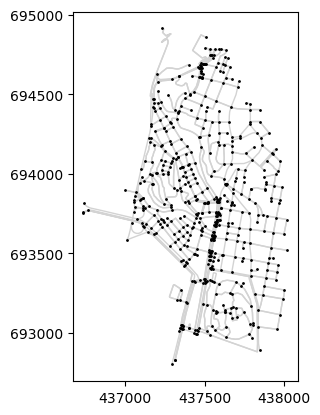

In [41]:
# Plot
fig,ax = plt.subplots(1,1)

nodes.plot(ax=ax,zorder=1,color='black',markersize=1)
edges.plot(ax=ax,zorder=0,color='lightgrey',linewidth=1)

## Select test street

(33, 5)


<Axes: >

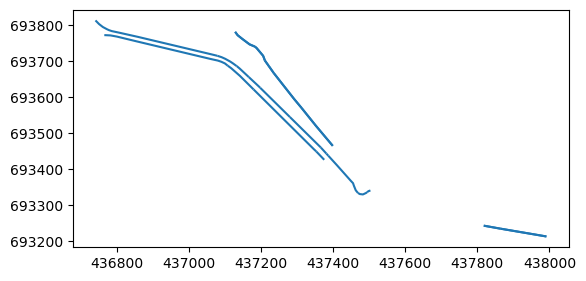

In [44]:
test_st_name = "Calle 77"
test_edges = edges.loc[edges.name == test_st_name].copy()
########## Also select nodes from edges when osmid is available in nodes input

# Show
print(test_edges.shape)
test_edges.plot()

## Function definitions

In [74]:
def get_multiline_angle(row):
    
    geom = row['geometry']
    
    if isinstance(geom, MultiLineString):
        # Get geometry
        multi_line = row.geometry
        
        # Get the first LineString in the MultiLineString
        first_line = multi_line.geoms[0]
        # Get the last LineString in the MultiLineString
        last_line = multi_line.geoms[-1]
        
        # Get the starting point (first coordinate of the first LineString)
        start_point = first_line.coords[0]
        # Get the ending point (last coordinate of the last LineString)
        end_point = last_line.coords[-1]

    elif isinstance(geom, LineString):
        
        # Get geometry
        line = row.geometry
        # Get the starting point
        start_point = line.coords[0]
        # Get the ending point
        end_point = line.coords[-1]
    
    # Calculate the differences in coordinates
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    # Calculate the angle in radians
    angle_radians = math.atan2(dy, dx)
    # Convert the angle to degrees
    angle_degrees = math.degrees(angle_radians)
    # If angle is negative, make positive
    if angle_degrees < 0:
        angle_degrees += 360
        
    # Change angle to 0° to 180° format
    if angle_degrees > 180:
        angle_reversed = angle_degrees - 180
        row['line_angle'] = angle_reversed
    else:
        row['line_angle'] = angle_degrees

    return row

## Test 01 - The way it is right now

In [95]:
# Find nearest line to each line using Hausdorff distance
def nearest_line(row, target_uniqueID, data_gdf, data_uniqueID, adjacent=(True,10), angle_consideration=(False,0),buffer_consideration=(False,0)):
    
    # For each row(line), set min_distance to nearest line found to infinite
    best_distance = float('inf')
    # For each row, nearest line hasn't been found yet
    nearest_line = None

    # If adjacent=True, clips data_gdf network to lines adjacent to current target_gdf row (line of interest).
    if adjacent[0]:
        # Create a buffer around the line of interest and clip the data_gdf lines that intersect it.
        # Will search for nearest lines using Hausdorff distance only in lines that intersect that buffer.
        line_buffer = row['geometry'].buffer(adjacent[1])
        adjacent_lines = data_gdf.clip(line_buffer)
        adjacent_lines = adjacent_lines.to_crs(projected_crs)
        
        # Prevent crash
        if len(adjacent_lines) == 0:
            print(f"Found no adjacent lines for {row[target_uniqueID]}.")
            return row
    else:
        # Do not clip data, consider full network
        adjacent_lines = data_gdf.copy()
    
    # For each row(line) in adjacent_lines (data_gdf):
    candidate_i = 0
    for _, data_row in adjacent_lines.iterrows():

        # Same line check
        # If using the same gdf as both data and target, avoid considering itself as the closest line.
        # (If any problem arises from this approach, could also not register if min_distance ==0)
        if (row['u'] == data_row['u']) & (row['v'] == data_row['v']):
            continue
        elif (row['u'] == data_row['v']) & (row['v'] == data_row['u']):
            continue
        
        # Find Hausdorff distance to adjacent line
        distance = row['geometry'].hausdorff_distance(data_row['geometry'])

        # If considering angle, register Hausdorff distance only if two conditions are met:
        # > Currently measured Hausdorff distance is less than the best_distance registered so far.
        # > The angle between lines does not exceed the requested consideration.
        
        if angle_consideration[0]:
            # Find absolute difference in direction of both lines
            angle_diff = abs(row['line_angle'] - data_row['line_angle'])

            # Register data
            if (distance < best_distance) and (angle_diff < angle_consideration[1]):

                if candidate_i==0: # First
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = data_row[data_uniqueID]
                    best_line = data_row['geometry']
                
                else: # Following
                    # Save second best (previous best)
                    second_best_distance = best_distance
                    second_best_nearest = best_nearest
                    second_best_line = best_line
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = data_row[data_uniqueID]
                    best_line = data_row['geometry']

                candidate_i+=1
                        
        # Not considering angle, register Hausdorff distance if:
        # > Currently measured Hausdorff distance is less than the best_distance registered so far.
        else:
            # Register data
            if distance < best_distance: # First
                
                if candidate_i==0:
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = data_row[data_uniqueID]
                    best_line = data_row['geometry']
                    
                else: # Following
                    # Save second best (previous best)
                    second_best_distance = best_distance
                    second_best_nearest = best_nearest
                    second_best_line = best_line
                    # Save current case (best)
                    best_distance = distance
                    best_nearest = data_row[data_uniqueID]
                    best_line = data_row['geometry']
                
                candidate_i+=1

    if candidate_i == 0:
        print(f"Found no similar line for {row[target_uniqueID]}.")
        return row
    
    # Finally, register result
    # If deciding between best option and second best option using buffer overlap:
    if (buffer_consideration[0]) and (best_distance>buffer_consideration[1]) and (candidate_i>1):
        
        # Apply function that identifies best line according to pct of overlap of buffers
        row_line = row['geometry']
        buff_dist = buffer_consideration[1]
        best_row = find_best_line(row_line, best_line, second_best_line, buff_dist)
        
        # Register result
        if best_row == '1':
            row['nearest_line'] = best_nearest
            row['hausdorff'] = best_distance
            row['buff_consid'] = 1
            print(f"Chose line closest distance line {best_nearest} over line {second_best_nearest} for row {row[target_uniqueID]}.")
        else:
            row['nearest_line'] = second_best_nearest
            row['hausdorff'] = second_best_distance
            row['buff_consid'] = 1
            print(f"Chose line farthest distance line {second_best_nearest} over line {best_nearest} for row {row[target_uniqueID]}.")
    
    else:
        row['nearest_line'] = best_nearest
        row['hausdorff'] = best_distance
        row['buff_consid'] = 0

    return row

In [96]:
# Create unique ID Street Network (OSMnx edge using u and v)
uniqueID = 'osmnx_id'
streets_gdf = test_edges.copy()
streets_gdf['u'] = streets_gdf['u'].astype('str')
streets_gdf['v'] = streets_gdf['v'] .astype('str')
streets_gdf[uniqueID]= streets_gdf['u']+ streets_gdf['v']

############ ANGLE CONSIDERATION
# Get OSMnx network lines angle
streets_gdf = streets_gdf.apply(get_multiline_angle,axis=1)
############ ANGLE CONSIDERATION

# Apply nearest_line() function to find closest line to each line in OSMnx network
streets_gdf = streets_gdf.apply(nearest_line, target_uniqueID=uniqueID, data_gdf=streets_gdf, data_uniqueID=uniqueID, adjacent=(True,30), angle_consideration=(True,45), buffer_consideration=(False,60), axis=1)

# Show
print(streets_gdf.shape)
streets_gdf.head(1)

(33, 10)


,u,v,key,name,geometry,osmnx_id,line_angle,nearest_line,hausdorff,buff_consid
6,428101531,8751449528,0,Calle 77,"LINESTRING (437077.925 693715.478, 437062.332 ...",4281015318751449528,163.795191,428106478428113484,47.60624,0


In [97]:
# Assigning same street check
streets_gdf.loc[streets_gdf.hausdorff==0]

,u,v,key,name,geometry,osmnx_id,line_angle,nearest_line,hausdorff,buff_consid


### Visual inspection

In [110]:
save_plots = True

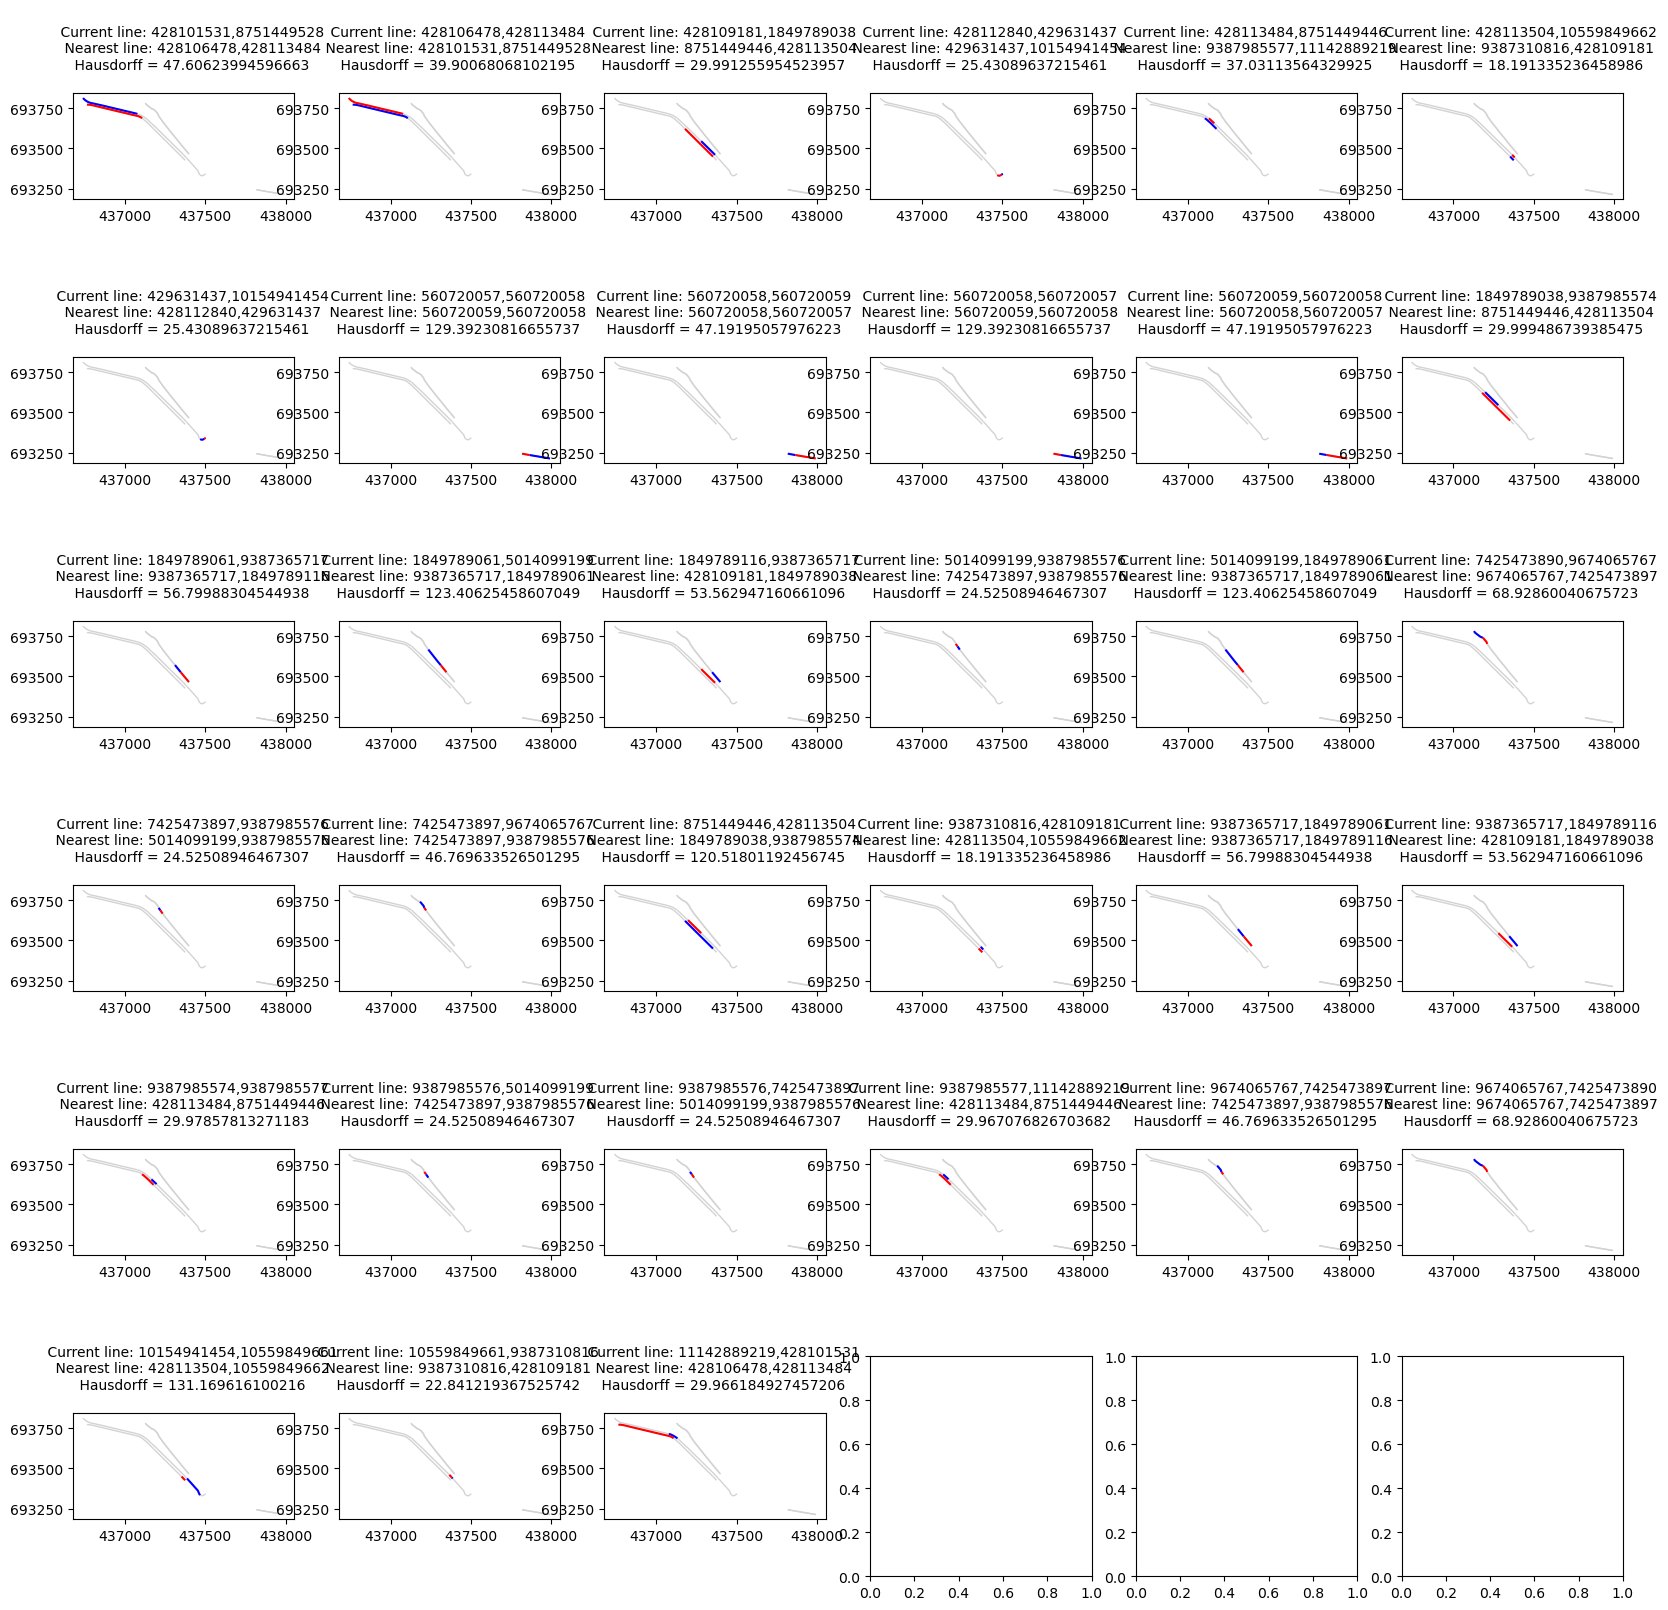

In [114]:
fig,axs = plt.subplots(6,6,figsize=(20,20))

i = 0
j = 0

for osmnx_id in list(streets_gdf.osmnx_id.unique()):

    # ----- LINES OF INTEREST
    # Current line
    current_line = streets_gdf.loc[streets_gdf.osmnx_id == osmnx_id]
    # Most similar line
    nearest = current_line.nearest_line.unique()[0]
    nearest_line = streets_gdf.loc[streets_gdf.osmnx_id == nearest]

    # ----- PLOTS
    # Current line plot
    current_line.plot(ax=axs[i,j],zorder=1,color='blue',linewidth=1.5)
    # Most similar line plot
    nearest_line.plot(ax=axs[i,j],zorder=1,color='red',linewidth=1.5)
    # Background plot
    streets_gdf.plot(ax=axs[i,j],zorder=0,color='lightgrey',linewidth=1)

    # Format
    hausdorff_distance = current_line.hausdorff.unique()[0]
    axs[i,j].set_title(f"""
    Current line: {current_line.u.unique()[0]},{current_line.v.unique()[0]}
    Nearest line: {nearest_line.u.unique()[0]},{nearest_line.v.unique()[0]}
    Hausdorff = {hausdorff_distance}
    """,fontsize=10)

    if j<5:
        j+=1
    else:
        j=0
        i+=1

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(accesibilidad_urbana + "output/figures/hausdorff_distance_test/hausdorff_calle77_test01.svg")

## Test 02 - Avoiding registering an edge (L2) following an edge (L1) as the most similar line to the first edge (L1).
#### __How to identify?__ --> When lines share a node (starting node) and the other (ending) node of each line is on the oposite direction, the distance between the ending nodes is greater than the greatest distance between each ending node and the starting node.

In [252]:
# Distance between two points
def distance(point1, point2):
    return round(math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 2)

# Line sequentiality check
def line_sequentiality_check(row,data_row):
    # If the candidate line (data_row) is a line that continues the path of the current line (row),
    # the code might assign it as the most similar line.
    # In order to avoid this:

    uniqueID = 'osmnx_id'

    # If both lines share any node, analyse the lines
    if (row['u'] == data_row['u']) | (row['v'] == data_row['v']) | (row['u'] == data_row['v']) | (row['v'] == data_row['u']):

        
        shared_count = 0 # If shared_count reaches 2, the line starts and ends in the same nodes.

        # Identify shared node and other (ending) nodes
        if (row['u'] == data_row['u']):
            shared_node = nodes.loc[nodes.osmid==row['u']].copy()
            ending_node_1 = nodes.loc[nodes.osmid==row['v']].copy()
            ending_node_2 = nodes.loc[nodes.osmid==data_row['v']].copy()
            shared_count+=1
        elif (row['v'] == data_row['v']):
            shared_node = nodes.loc[nodes.osmid==row['v']].copy()
            ending_node_1 = nodes.loc[nodes.osmid==row['u']].copy()
            ending_node_2 = nodes.loc[nodes.osmid==data_row['u']].copy()
            shared_count+=1
        elif (row['u'] == data_row['v']):
            shared_node = nodes.loc[nodes.osmid==row['u']].copy()
            ending_node_1 = nodes.loc[nodes.osmid==row['v']].copy()
            ending_node_2 = nodes.loc[nodes.osmid==data_row['u']].copy()
            shared_count+=1
        elif (row['v'] == data_row['u']):
            shared_node = nodes.loc[nodes.osmid==row['v']].copy()
            ending_node_1 = nodes.loc[nodes.osmid==row['u']].copy()
            ending_node_2 = nodes.loc[nodes.osmid==data_row['v']].copy()
            shared_count+=1

        if shared_count == 2:
            print(f"Lines {row[uniqueID]} and {data_row[uniqueID]} have the same starting and ending points.")
            return 2                                                                                                     

        # Find nodes coordinates
        shared_node_coords = shared_node['geometry'].unique()[0].coords[0]
        ending_node_1_coords = ending_node_1['geometry'].unique()[0].coords[0]
        ending_node_2_coords = ending_node_2['geometry'].unique()[0].coords[0]
        
        # Find distances of interest
        shared_ending_node_1 = distance(shared_node_coords, ending_node_1_coords)
        shared_ending_node_2 = distance(shared_node_coords, ending_node_2_coords)
        endings = distance(ending_node_1_coords, ending_node_2_coords)

        # If the distance between the ending nodes is greater than the distance between each ending node and the shared node,
        # most likely they are two sequential edges. [NODE_A <----------EDGE----------> SHARED_NODE <----------EDGE----------> NODE_B]
        
        if (endings > shared_ending_node_1) and (endings > shared_ending_node_2):
            print(f"Lines {row[uniqueID]} and {data_row[uniqueID]} are contiguous.")
            return 1
        else:
            return 0
    
    # If lines don't share any node, cant be sequential
    else:
        return 0

In [253]:
# Find nearest line to each line using Hausdorff distance
def nearest_line(row, target_uniqueID, data_gdf, data_uniqueID, adjacent=(True,10), angle_consideration=(False,0),buffer_consideration=(False,0)):
    
    # For each row(line), set min_distance to nearest line found to infinite
    best_distance = float('inf')
    # For each row, nearest line hasn't been found yet
    nearest_line = None

    # If adjacent=True, clips data_gdf network to lines adjacent to current target_gdf row (line of interest).
    if adjacent[0]:
        # Create a buffer around the line of interest and clip the data_gdf lines that intersect it.
        # Will search for nearest lines using Hausdorff distance only in lines that intersect that buffer.
        line_buffer = row['geometry'].buffer(adjacent[1])
        adjacent_lines = data_gdf.clip(line_buffer)
        adjacent_lines = adjacent_lines.to_crs(projected_crs)
        
        # Prevent crash
        if len(adjacent_lines) == 0:
            print(f"Found no adjacent lines for {row[target_uniqueID]}.")
            return row
    else:
        # Do not clip data, consider full network
        adjacent_lines = data_gdf.copy()
    
    # For each row(line) in adjacent_lines (data_gdf):
    candidate_i = 0
    for _, data_row in adjacent_lines.iterrows():

        ########## ########## ########## ADDED CODE STARTS
        
        # SAME LINE CHECK
        # If using the same gdf as both data and target, avoid considering itself as the closest line.
        # (If any problem arises from this approach, could also not register if min_distance ==0)
        if (row['u'] == data_row['u']) & (row['v'] == data_row['v']):
            continue
        elif (row['u'] == data_row['v']) & (row['v'] == data_row['u']):
            continue
            
        ########## ########## ########## ADDED CODE ENDS
        
        # Find Hausdorff distance to adjacent line
        distance = row['geometry'].hausdorff_distance(data_row['geometry'])

        # If considering angle, register Hausdorff distance only if two conditions are met:
        # > Currently measured Hausdorff distance is less than the best_distance registered so far.
        # > The angle between lines does not exceed the requested consideration.
        
        if angle_consideration[0]:
            # Find absolute difference in direction of both lines
            angle_diff = abs(row['line_angle'] - data_row['line_angle'])

            # Register data
            if (distance < best_distance) and (angle_diff < angle_consideration[1]):

                # Line sequentiality check
                sequentiality = line_sequentiality_check(row,data_row)
                
                # If lines show sequence, do not register
                if sequentiality == 1:
                    continue
                    
                # Else, register
                else:
                    if candidate_i==0: # First
                        # Save current case (best)
                        best_distance = distance
                        best_nearest = data_row[data_uniqueID]
                        best_line = data_row['geometry']
                    
                    else: # Following
                        # Save second best (previous best)
                        second_best_distance = best_distance
                        second_best_nearest = best_nearest
                        second_best_line = best_line
                        # Save current case (best)
                        best_distance = distance
                        best_nearest = data_row[data_uniqueID]
                        best_line = data_row['geometry']
    
                    candidate_i+=1
                    
                        
        # Not considering angle, register Hausdorff distance if:
        # > Currently measured Hausdorff distance is less than the best_distance registered so far.
        else:
            # Register data
            if distance < best_distance: # First
                 # Line sequentiality check
                sequentiality = line_sequentiality_check(row,data_row)
                
                # If lines show sequence, do not register
                if sequentiality == 1:
                    continue
                    
                # Else, register
                else:
                    if candidate_i==0:
                        # Save current case (best)
                        best_distance = distance
                        best_nearest = data_row[data_uniqueID]
                        best_line = data_row['geometry']
                        
                    else: # Following
                        # Save second best (previous best)
                        second_best_distance = best_distance
                        second_best_nearest = best_nearest
                        second_best_line = best_line
                        # Save current case (best)
                        best_distance = distance
                        best_nearest = data_row[data_uniqueID]
                        best_line = data_row['geometry']
                    
                    candidate_i+=1

    if candidate_i == 0:
        print(f"Found no similar line for {row[target_uniqueID]}.")
        return row
    
    # Finally, register result
    # If deciding between best option and second best option using buffer overlap:
    if (buffer_consideration[0]) and (best_distance>buffer_consideration[1]) and (candidate_i>1):
        
        # Apply function that identifies best line according to pct of overlap of buffers
        row_line = row['geometry']
        buff_dist = buffer_consideration[1]
        best_row = find_best_line(row_line, best_line, second_best_line, buff_dist)
        
        # Register result
        if best_row == '1':
            row['nearest_line'] = best_nearest
            row['hausdorff'] = best_distance
            row['buff_consid'] = 1
            print(f"Chose line closest distance line {best_nearest} over line {second_best_nearest} for row {row[target_uniqueID]}.")
        else:
            row['nearest_line'] = second_best_nearest
            row['hausdorff'] = second_best_distance
            row['buff_consid'] = 1
            print(f"Chose line farthest distance line {second_best_nearest} over line {best_nearest} for row {row[target_uniqueID]}.")
    
    else:
        row['nearest_line'] = best_nearest
        row['hausdorff'] = best_distance
        row['buff_consid'] = 0

    return row

In [255]:
# Create unique ID Street Network (OSMnx edge using u and v)
uniqueID = 'osmnx_id'
streets_gdf = test_edges.copy()
streets_gdf['u'] = streets_gdf['u'].astype('str')
streets_gdf['v'] = streets_gdf['v'] .astype('str')
streets_gdf[uniqueID]= streets_gdf['u']+ streets_gdf['v']
streets_gdf['u'] = streets_gdf['u'].astype('int')
streets_gdf['v'] = streets_gdf['v'] .astype('int')

############ ANGLE CONSIDERATION
# Get OSMnx network lines angle
streets_gdf = streets_gdf.apply(get_multiline_angle,axis=1)
############ ANGLE CONSIDERATION

# Apply nearest_line() function to find closest line to each line in OSMnx network
test_02 = streets_gdf.apply(nearest_line, target_uniqueID=uniqueID, data_gdf=streets_gdf, data_uniqueID=uniqueID, adjacent=(True,30), angle_consideration=(True,45), buffer_consideration=(False,60), axis=1)

# Show
print(test_02.shape)
test_02.head(1)

Lines 4281015318751449528 and 11142889219428101531 are contiguous.
Lines 428106478428113484 and 4281134848751449446 are contiguous.
Lines 428112840429631437 and 42963143710154941454 are contiguous.
Found no similar line for 428112840429631437.
Lines 4281134848751449446 and 8751449446428113504 are contiguous.
Lines 42963143710154941454 and 428112840429631437 are contiguous.
Found no similar line for 42963143710154941454.
Lines 560720057560720058 and 560720059560720058 are contiguous.
Lines 560720057560720058 and 560720058560720059 are contiguous.
Found no similar line for 560720057560720058.
Lines 560720058560720059 and 560720058560720057 are contiguous.
Lines 560720058560720059 and 560720057560720058 are contiguous.
Found no similar line for 560720058560720059.
Lines 560720058560720057 and 560720059560720058 are contiguous.
Lines 560720058560720057 and 560720058560720059 are contiguous.
Found no similar line for 560720058560720057.
Lines 560720059560720058 and 560720058560720057 are co

,buff_consid,geometry,hausdorff,key,line_angle,name,nearest_line,osmnx_id,u,v
6,0.0,"LINESTRING (437077.925 693715.478, 437062.332 ...",47.60624,0,163.795191,Calle 77,428106478428113484,4281015318751449528,428101531,8751449528


In [259]:
test_02.loc[test_02.nearest_line.isna()]

,buff_consid,geometry,hausdorff,key,line_angle,name,nearest_line,osmnx_id,u,v
9,NaN,"LINESTRING (437502.948 693341.617, 437497.547 ...",NaN,0,27.506208,Calle 77,NaN,428112840429631437,428112840,429631437
31,NaN,"LINESTRING (437493.562 693336.730, 437490.783 ...",NaN,0,4.401041,Calle 77,NaN,42963143710154941454,429631437,10154941454
81,NaN,"LINESTRING (437991.602 693213.841, 437864.037 ...",NaN,0,170.358339,Calle 77,NaN,560720057560720058,560720057,560720058
85,NaN,"LINESTRING (437864.037 693235.512, 437817.586 ...",NaN,0,169.833444,Calle 77,NaN,560720058560720059,560720058,560720059
86,NaN,"LINESTRING (437864.037 693235.512, 437991.602 ...",NaN,0,170.358339,Calle 77,NaN,560720058560720057,560720058,560720057
88,NaN,"LINESTRING (437817.586 693243.842, 437864.037 ...",NaN,0,169.833444,Calle 77,NaN,560720059560720058,560720059,560720058
296,NaN,"LINESTRING (437311.626 693570.892, 437347.186 ...",NaN,0,128.760079,Calle 77,NaN,18497890619387365717,1849789061,9387365717
957,NaN,"LINESTRING (437127.366 693781.996, 437134.302 ...",NaN,0,143.252471,Calle 77,NaN,74254738909674065767,7425473890,9674065767
1111,NaN,"LINESTRING (437347.186 693526.601, 437311.626 ...",NaN,0,128.760079,Calle 77,NaN,93873657171849789061,9387365717,1849789061
1227,NaN,"LINESTRING (437182.597 693740.757, 437167.206 ...",NaN,0,143.252471,Calle 77,NaN,96740657677425473890,9674065767,7425473890


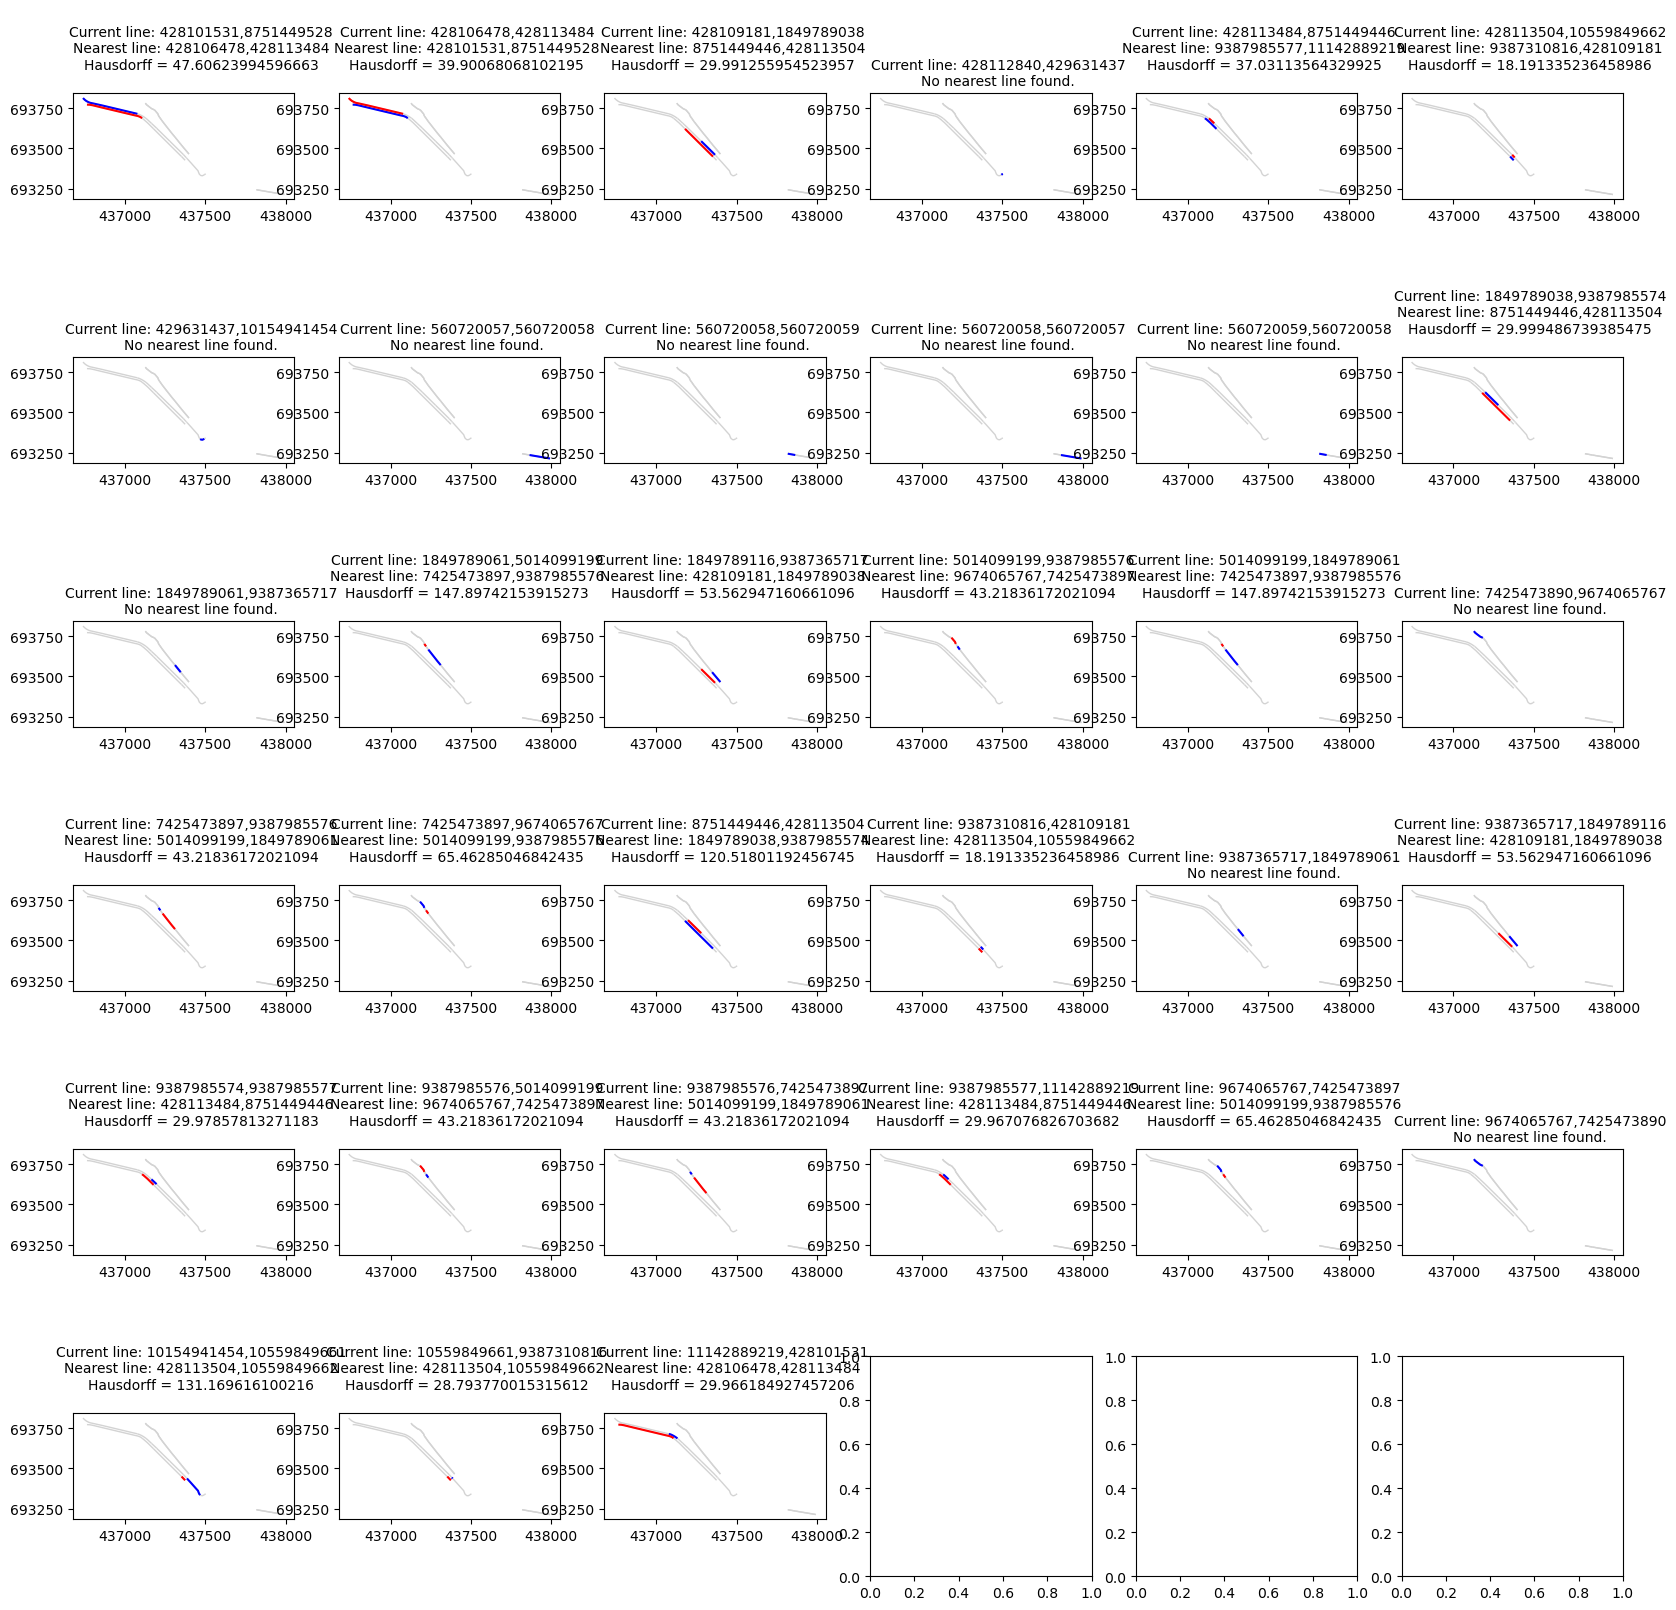

In [274]:
streets_gdf = test_02.copy()

fig,axs = plt.subplots(6,6,figsize=(20,20))

i = 0
j = 0

for osmnx_id in list(streets_gdf.osmnx_id.unique()):

    # ----- LINES OF INTEREST
    # Current line
    current_line = streets_gdf.loc[streets_gdf.osmnx_id == osmnx_id]
    # Most similar line
    nearest = current_line.nearest_line.unique()[0]

    # If there is a registered nearest for current line:
    if type(nearest) == str:
        # Get nearest line from gdf
        nearest_line = streets_gdf.loc[streets_gdf.osmnx_id == nearest]
    
        # ----- PLOT
        # Current line plot
        current_line.plot(ax=axs[i,j],zorder=1,color='blue',linewidth=1.5)
        # Most similar line plot
        nearest_line.plot(ax=axs[i,j],zorder=1,color='red',linewidth=1.5)
        # Background plot
        streets_gdf.plot(ax=axs[i,j],zorder=0,color='lightgrey',linewidth=1)
    
        # ----- PLOT FORMAT
        hausdorff_distance = current_line.hausdorff.unique()[0]
        axs[i,j].set_title(f"""
        Current line: {current_line.u.unique()[0]},{current_line.v.unique()[0]}
        Nearest line: {nearest_line.u.unique()[0]},{nearest_line.v.unique()[0]}
        Hausdorff = {hausdorff_distance}
        """,fontsize=10)
    
        if j<5:
            j+=1
        else:
            j=0
            i+=1

    # If no registered nearest for current line
    else:
        # ----- PLOT
        # Current line plot
        current_line.plot(ax=axs[i,j],zorder=1,color='blue',linewidth=1.5)
        # Background plot
        streets_gdf.plot(ax=axs[i,j],zorder=0,color='lightgrey',linewidth=1)

        # ----- PLOT FORMAT
        axs[i,j].set_title(f"""
        Current line: {current_line.u.unique()[0]},{current_line.v.unique()[0]}
        No nearest line found.""",fontsize=10)

        if j<5:
            j+=1
        else:
            j=0
            i+=1

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(accesibilidad_urbana + "output/figures/hausdorff_distance_test/hausdorff_calle77_test02.svg")